In [1]:
import numpy as np
import glob
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from bratsreg_model_stage import (
    SpatialTransform_unit, SpatialTransformNearest_unit,
)
from Functions import save_img



In [8]:
num_d=1
result = "Result"

In [9]:
use_cuda=False
device = torch.device("cuda" if use_cuda else "cpu")
#transform = SpatialTransform_unit().to(device)
transform = SpatialTransformNearest_unit().to(device)

def transform_seg(num_d, result, direction="X_Y"):
    """
    Transform segmentation image to deformed image.
    :param num_d: number of deformation image
    :param result: folder name
    :param direction: direction of deformation
    """
    F_X_Y_file=f"../{result}/{num_d}F_X_Y.nii.gz"
    F_Y_X_file=f"../{result}/{num_d}F_Y_X.nii.gz"
    grid_unit_file=f"../{result}/{num_d}grid_unit.nii.gz"

    # Load Numpy segmentation file
    segmentation_list = sorted(glob.glob("../Dataset/test/seg_out_*.npy"))
    # print(segmentation_list)
    seg_image_file= segmentation_list[num_d-1] #f"../{result}/{num_d}.npy"

    # labels
    seg_out = np.load(seg_image_file)
    seg_out = torch.from_numpy(seg_out).to(device)
    seg_out = seg_out.unsqueeze(0).unsqueeze(1)
    # print(seg_out.shape)
    if direction == "X_Y":
        deformation_file= F_X_Y_file
    else:
        deformation_file= F_Y_X_file
        
    template = nib.load(deformation_file)
    header, affine = template.header, template.affine


    # Matriz de transformacion
    F_X_Y = torch.from_numpy(nib.load(F_X_Y_file).get_fdata()).to(device)
    F_X_Y = F_X_Y.unsqueeze(0)

    F_Y_X = torch.from_numpy(nib.load(F_Y_X_file).get_fdata()).to(device)
    F_Y_X = F_Y_X.unsqueeze(0)
    grid_unit = torch.from_numpy(nib.load(grid_unit_file).get_fdata()).to(device)
    grid_unit = grid_unit.unsqueeze(0)
    #print(F_X_Y.shape, F_Y_X.shape, grid_unit.shape)

    warped_seg = transform(seg_out, F_X_Y.permute(0, 2, 3, 4, 1), grid_unit)

    save_img(
                warped_seg.cpu().numpy()[0],
                f"../{result}/{num_d}segmentation.nii.gz",
                header,
                affine,
            )
    return warped_seg, header, affine

In [10]:
warped_seg, header, affine=transform_seg(num_d, result)

## Transformar todas las segmentaciones

In [13]:
result="Result_D"
for i in range(36):
    _,_,_=transform_seg(i+1, result)

In [5]:
def display_slice(slice_data, title=None):
  plt.imshow(slice_data.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
  plt.colorbar()
  if title:
    plt.title(title)
  plt.show()

def display_slice_with_segmentation(mri_slice, segmentation_slice, title=None):
    plt.imshow(mri_slice.squeeze(), cmap='gray')  # Squeeze to remove channel dim if present
    plt.imshow(segmentation_slice.squeeze(), cmap='jet', alpha=0.3)  # Overlay segmentation with transparency
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

torch.Size([1, 1, 240, 240, 155])


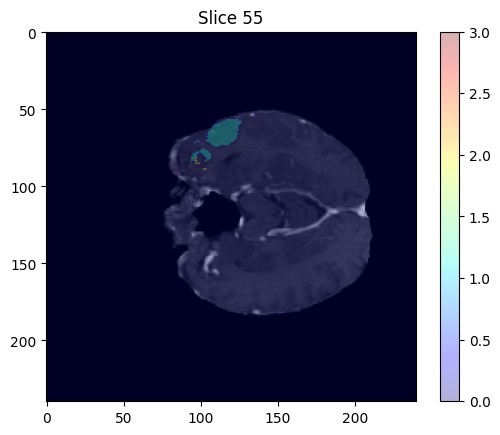

['../Dataset/test\\UPENN-GBM-00036_21\\UPENN-GBM-00036_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00042_21\\UPENN-GBM-00042_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00045_21\\UPENN-GBM-00045_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00051_21\\UPENN-GBM-00051_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00052_21\\UPENN-GBM-00052_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00055_21\\UPENN-GBM-00055_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00084_21\\UPENN-GBM-00084_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00086_21\\UPENN-GBM-00086_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00088_21\\UPENN-GBM-00088_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00122_21\\UPENN-GBM-00122_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00128_21\\UPENN-GBM-00128_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00129_21\\UPENN-GBM-00129_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00133_21\\UPENN-GBM-00133_21_T1GD.nii.gz', '../Dataset/test\\UPENN-GBM-00134_21\\UPENN-GBM-00134_21_T1GD.nii.gz', '../D

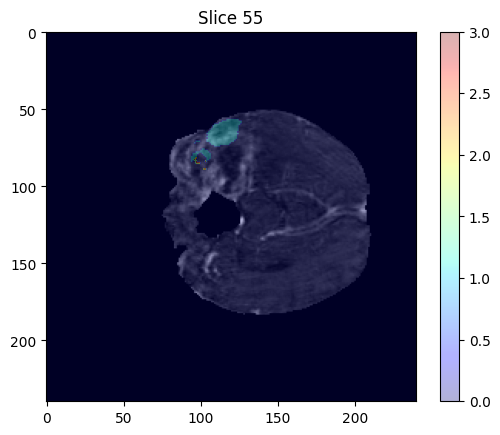

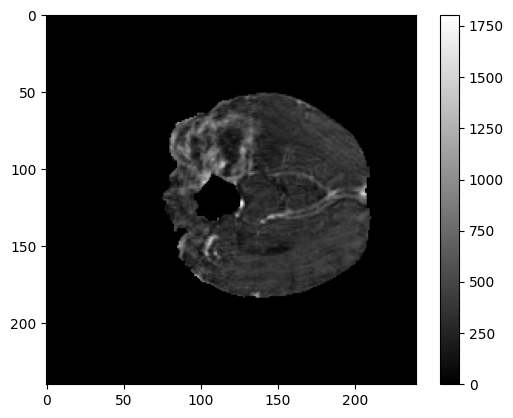

In [6]:
# Plot warped_seg using matplotlib
print(warped_seg.shape)

slice_num = 55
selected_slice_w = warped_seg[0, 0, :, :, slice_num]

MRI= nib.load(f"../{result}/{num_d}_X_Y.nii.gz").get_fdata()
selected_slice_MRI = MRI[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI, selected_slice_w, title=f"Slice {slice_num}")

recurrence_t1ce_list = sorted(glob.glob("../Dataset/test/*/UPENN-GBM-*_21*_T1GD.nii.gz"))
print(recurrence_t1ce_list)
MRI_R= nib.load(recurrence_t1ce_list[num_d-1] ).get_fdata()
selected_slice_MRI_R = MRI_R[:, :, slice_num]
display_slice_with_segmentation(selected_slice_MRI_R, selected_slice_w, title=f"Slice {slice_num}")

display_slice(selected_slice_MRI_R, title=None)

In [43]:
# Normalizar la imagen MRI y la segmentación
def combine(warped_seg, MRI, output):
    warped_seg_data = warped_seg.squeeze().cpu().numpy()
    MRI_norm = (MRI - np.min(MRI)) / (np.max(MRI) - np.min(MRI))
    warped_seg_norm = (warped_seg_data - np.min(warped_seg_data)) / (np.max(warped_seg_data) - np.min(warped_seg_data))

    # Definir la transparencia de la superposición (entre 0 y 1, donde 0 es totalmente transparente y 1 es opaco)
    transparency = 0.5

    # Superponer la segmentación en la imagen MRI con la transparencia especificada
    overlay = MRI_norm + transparency * warped_seg_norm

    save_img(
                overlay,
                output,
                header,
                affine,
            )
    return overlay

In [44]:
_=combine(warped_seg, MRI, f"../{result}/{num_d}overlay.nii.gz")
_=combine(warped_seg, MRI_R, f"../{result}/{num_d}overlay_R.nii.gz")